In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tabulate import tabulate 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [3]:
class_names = dataset.class_names
num_classes = len(class_names)
class_names, num_classes

(['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'], 3)

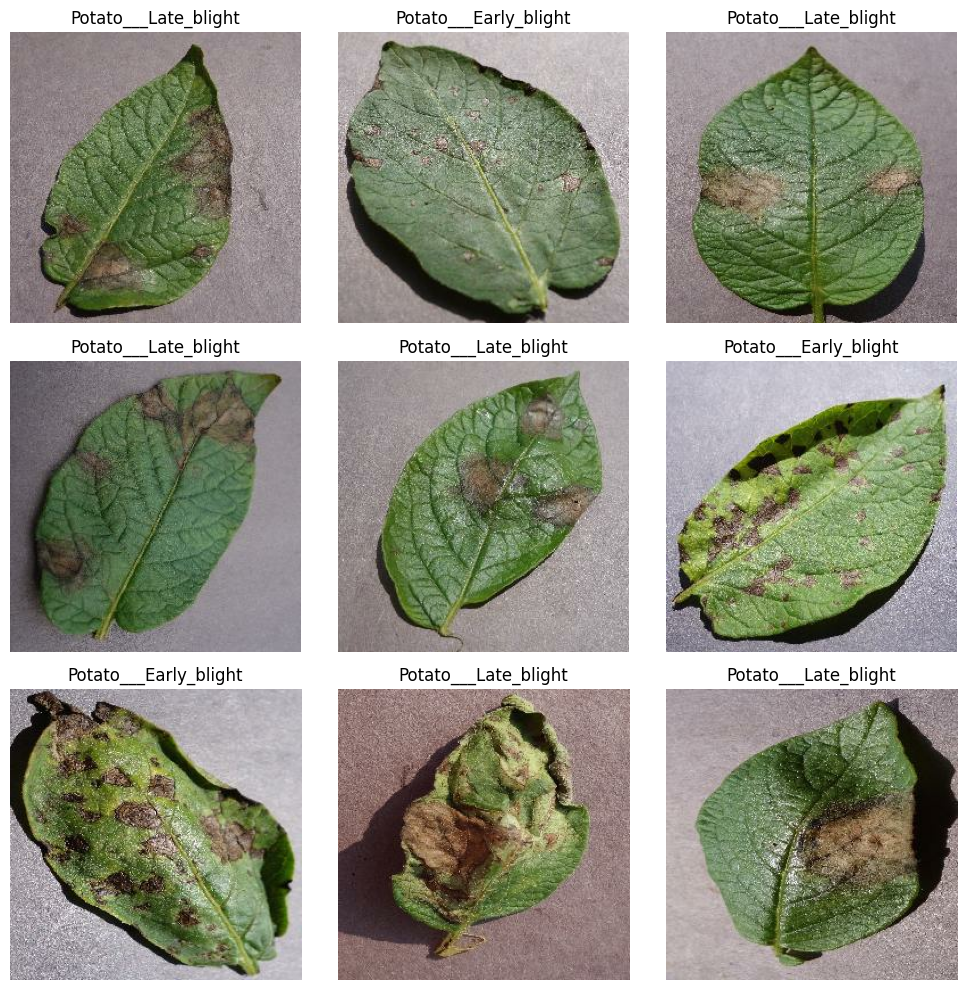

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [5]:
train_size = (0.8 * len(dataset))
train_size

54.400000000000006

In [6]:
train_ds = dataset.take(54)
len(train_ds)

54

In [7]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [8]:
val_size = (0.1 * len(dataset))
val_size

6.800000000000001

In [9]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [10]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False

model = models.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\Sauradeep\AppData\Local\Temp\ipykernel_2444\407372819.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))


In [13]:
EPOCHS = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8029 - loss: 0.4534 - val_accuracy: 0.9688 - val_loss: 0.1075
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 954ms/step - accuracy: 0.9641 - loss: 0.1090 - val_accuracy: 0.9844 - val_loss: 0.0391
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 968ms/step - accuracy: 0.9807 - loss: 0.0594 - val_accuracy: 0.9896 - val_loss: 0.0363
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9842 - loss: 0.0383 - val_accuracy: 0.9844 - val_loss: 0.0377
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9949 - loss: 0.0298 - val_accuracy: 0.9844 - val_loss: 0.0339
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9918 - loss: 0.0279 - val_accuracy: 0.9844 - val_loss: 0.0364
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9959 - loss: 0.0203 - val_accuracy: 0.9948 - val_loss: 0.0337
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9983 - loss: 0.0114 - val_accuracy: 0.9844 - val

In [22]:
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 738ms/step - accuracy: 0.9724 - loss: 0.0655
Test Accuracy: 0.9741


In [23]:
y_true, y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


In [16]:
# Predictions on Validation Set
val_y_true, val_y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    val_y_true.extend(labels.numpy())
    val_y_pred.extend(np.argmax(preds, axis=1))

# Predictions on Test Set
test_y_true, test_y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images)
    test_y_true.extend(labels.numpy())
    test_y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


In [24]:
# Create Validation Report
val_report = classification_report(val_y_true, val_y_pred, target_names=class_names, output_dict=True)
val_report_df = pd.DataFrame(val_report).transpose()[['precision', 'recall', 'f1-score', 'support']]
val_report_df = val_report_df.round(2)

# Create Test Report
test_report = classification_report(test_y_true, test_y_pred, target_names=class_names, output_dict=True)
test_report_df = pd.DataFrame(test_report).transpose()[['precision', 'recall', 'f1-score', 'support']]
test_report_df = test_report_df.round(2)

# Display as tables
display(val_report_df.style.set_caption("Validation Report").set_table_styles([{
    'selector': 'caption',
    'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]
}]))

display(test_report_df.style.set_caption("Test Report").set_table_styles([{
    'selector': 'caption',
    'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]
}]))

,precision,recall,f1-score,support
Potato___Early_blight,1.000000,1.000000,1.000000,102.000000
Potato___Late_blight,1.000000,0.990000,0.990000,82.000000
Potato___healthy,0.890000,1.000000,0.940000,8.000000
accuracy,0.990000,0.990000,0.990000,0.990000
macro avg,0.960000,1.000000,0.980000,192.000000
weighted avg,1.000000,0.990000,0.990000,192.000000


,precision,recall,f1-score,support
Potato___Early_blight,1.000000,0.980000,0.990000,127.000000
Potato___Late_blight,0.960000,0.980000,0.970000,87.000000
Potato___healthy,0.890000,0.890000,0.890000,18.000000
accuracy,0.970000,0.970000,0.970000,0.970000
macro avg,0.950000,0.950000,0.950000,232.000000
weighted avg,0.970000,0.970000,0.970000,232.000000


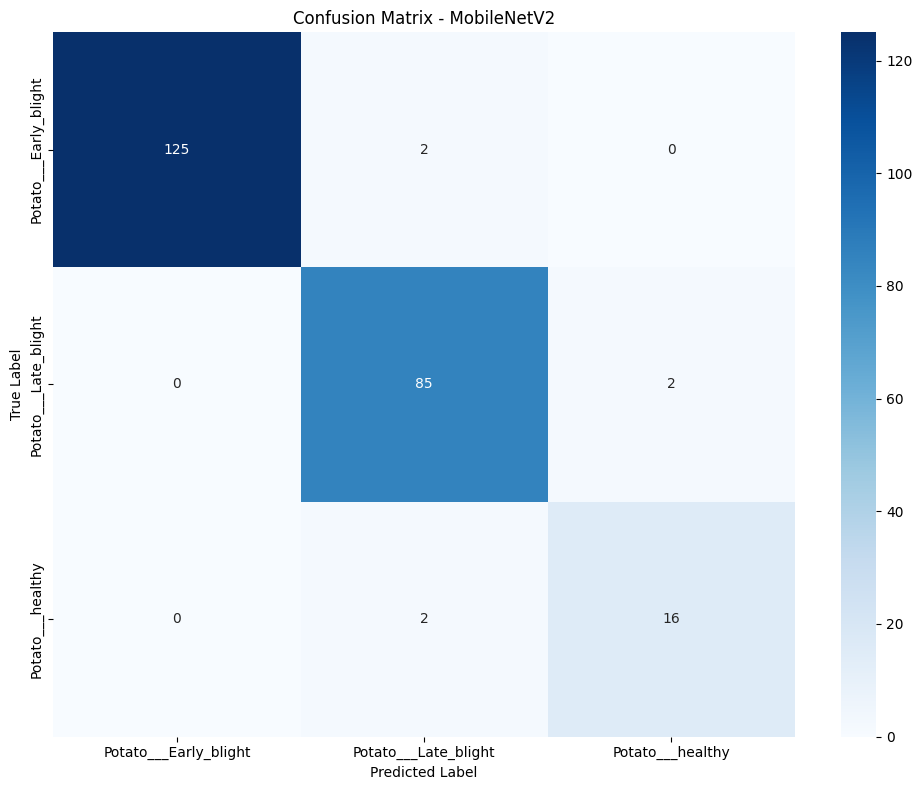

In [25]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - MobileNetV2")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

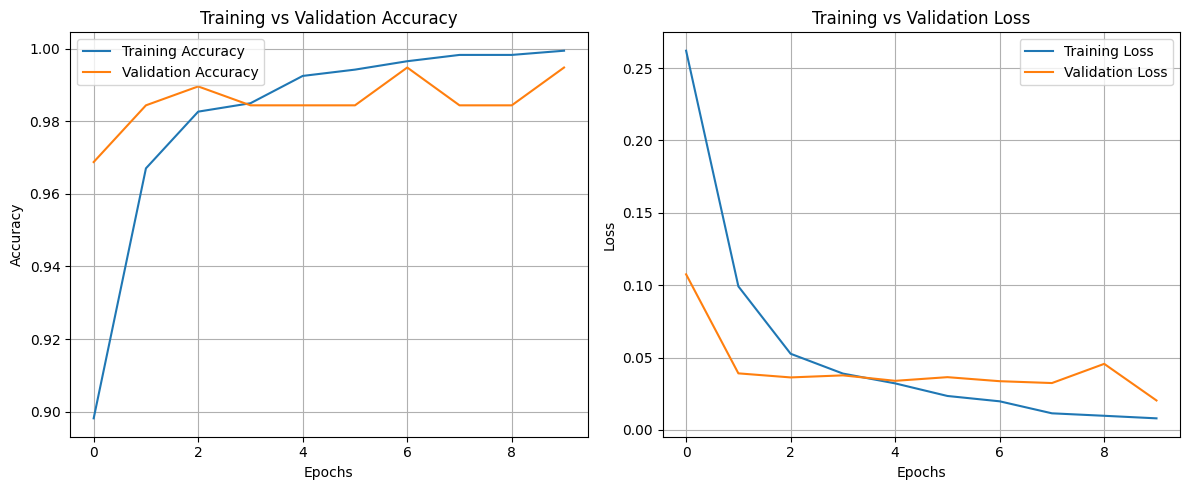

In [26]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 

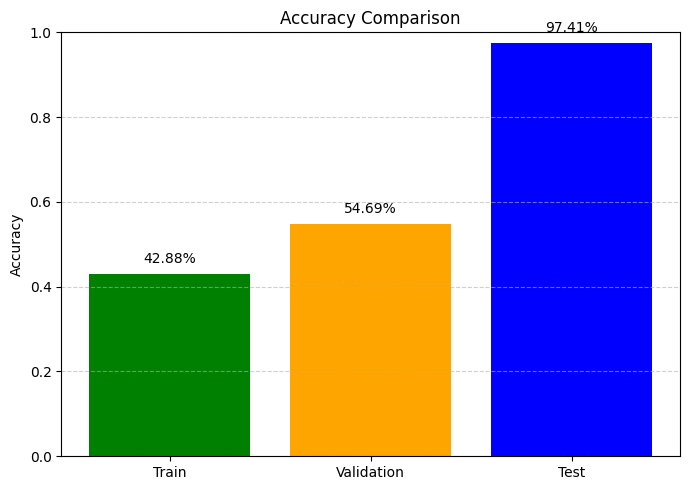

In [27]:
train_preds, val_preds = [], []
for images, labels in train_ds:
    pred = model.predict(images)
    train_preds.extend(np.argmax(pred, axis=1))

for images, labels in val_ds:
    pred = model.predict(images)
    val_preds.extend(np.argmax(pred, axis=1))

train_labels = np.concatenate([labels.numpy() for _, labels in train_ds])
val_labels = np.concatenate([labels.numpy() for _, labels in val_ds])

train_acc = accuracy_score(train_labels, train_preds)
val_acc = accuracy_score(val_labels, val_preds)
test_acc = accuracy_score(y_true, y_pred)

plt.figure(figsize=(7, 5))
plt.bar(['Train', 'Validation', 'Test'], [train_acc, val_acc, test_acc], color=['green', 'orange', 'blue'])
plt.ylim(0, 1)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
for i, acc in enumerate([train_acc, val_acc, test_acc]):
    plt.text(i, acc + 0.02, f"{acc:.2%}", ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [31]:
model.save("../models/mobilenetv2_model.keras")  